## Problem Statement:

The goal of this analysis is to develop a predictive model that can assess air quality levels in various regions based on multiple environmental and demographic factors.

## The target variable, Air Quality Levels, is categorized into four classes:
   * Good: Clean air with low pollution levels.
   * Moderate: Acceptable air quality, but with some pollutants present.
   * Poor: Noticeable pollution that may cause health issues for sensitive groups.
   * Hazardous: Highly polluted air, posing serious health risks to the population.

## Importing Essential libraries

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, auc
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

## Step 1: Load and Explore the Dataset

In [4]:
df = pd.read_csv('C:/161815Project/161815Project/DecProjects/ML/pollution_dataset.csv')

In [5]:
df.head()

Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [7]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


Temperature     Humidity        PM2.5         PM10          NO2  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     30.029020    70.056120    20.142140    30.218360    26.412100   
std       6.720661    15.863577    24.554546    27.349199     8.895356   
min      13.400000    36.000000     0.000000    -0.200000     7.400000   
25%      25.100000    58.300000     4.600000    12.300000    20.100000   
50%      29.000000    69.800000    12.000000    21.700000    25.300000   
75%      34.000000    80.300000    26.100000    38.100000    31.900000   
max      58.600000   128.100000   295.000000   315.800000    64.900000   

               SO2           CO  Proximity_to_Industrial_Areas  \
count  5000.000000  5000.000000                    5000.000000   
mean     10.014820     1.500354                       8.425400   
std       6.750303     0.546027                       3.610944   
min      -6.200000     0.650000                       2.500000   
25%       5.100000     1.030000                       5.400000   
50%       8.000000     1.410000                       7.900000   
75%      13.725000     1.840000                      11.100000   
max      44.900000     3.720000                      25.800000   

       Population_Density  
count         5000.000000  
mean           497.423800  
std            152.754084  
min            188.000000  
25%            381.000000  
50%            494.000000  
75%            600.000000  
max            957.000000

**Vizulaisation of data**

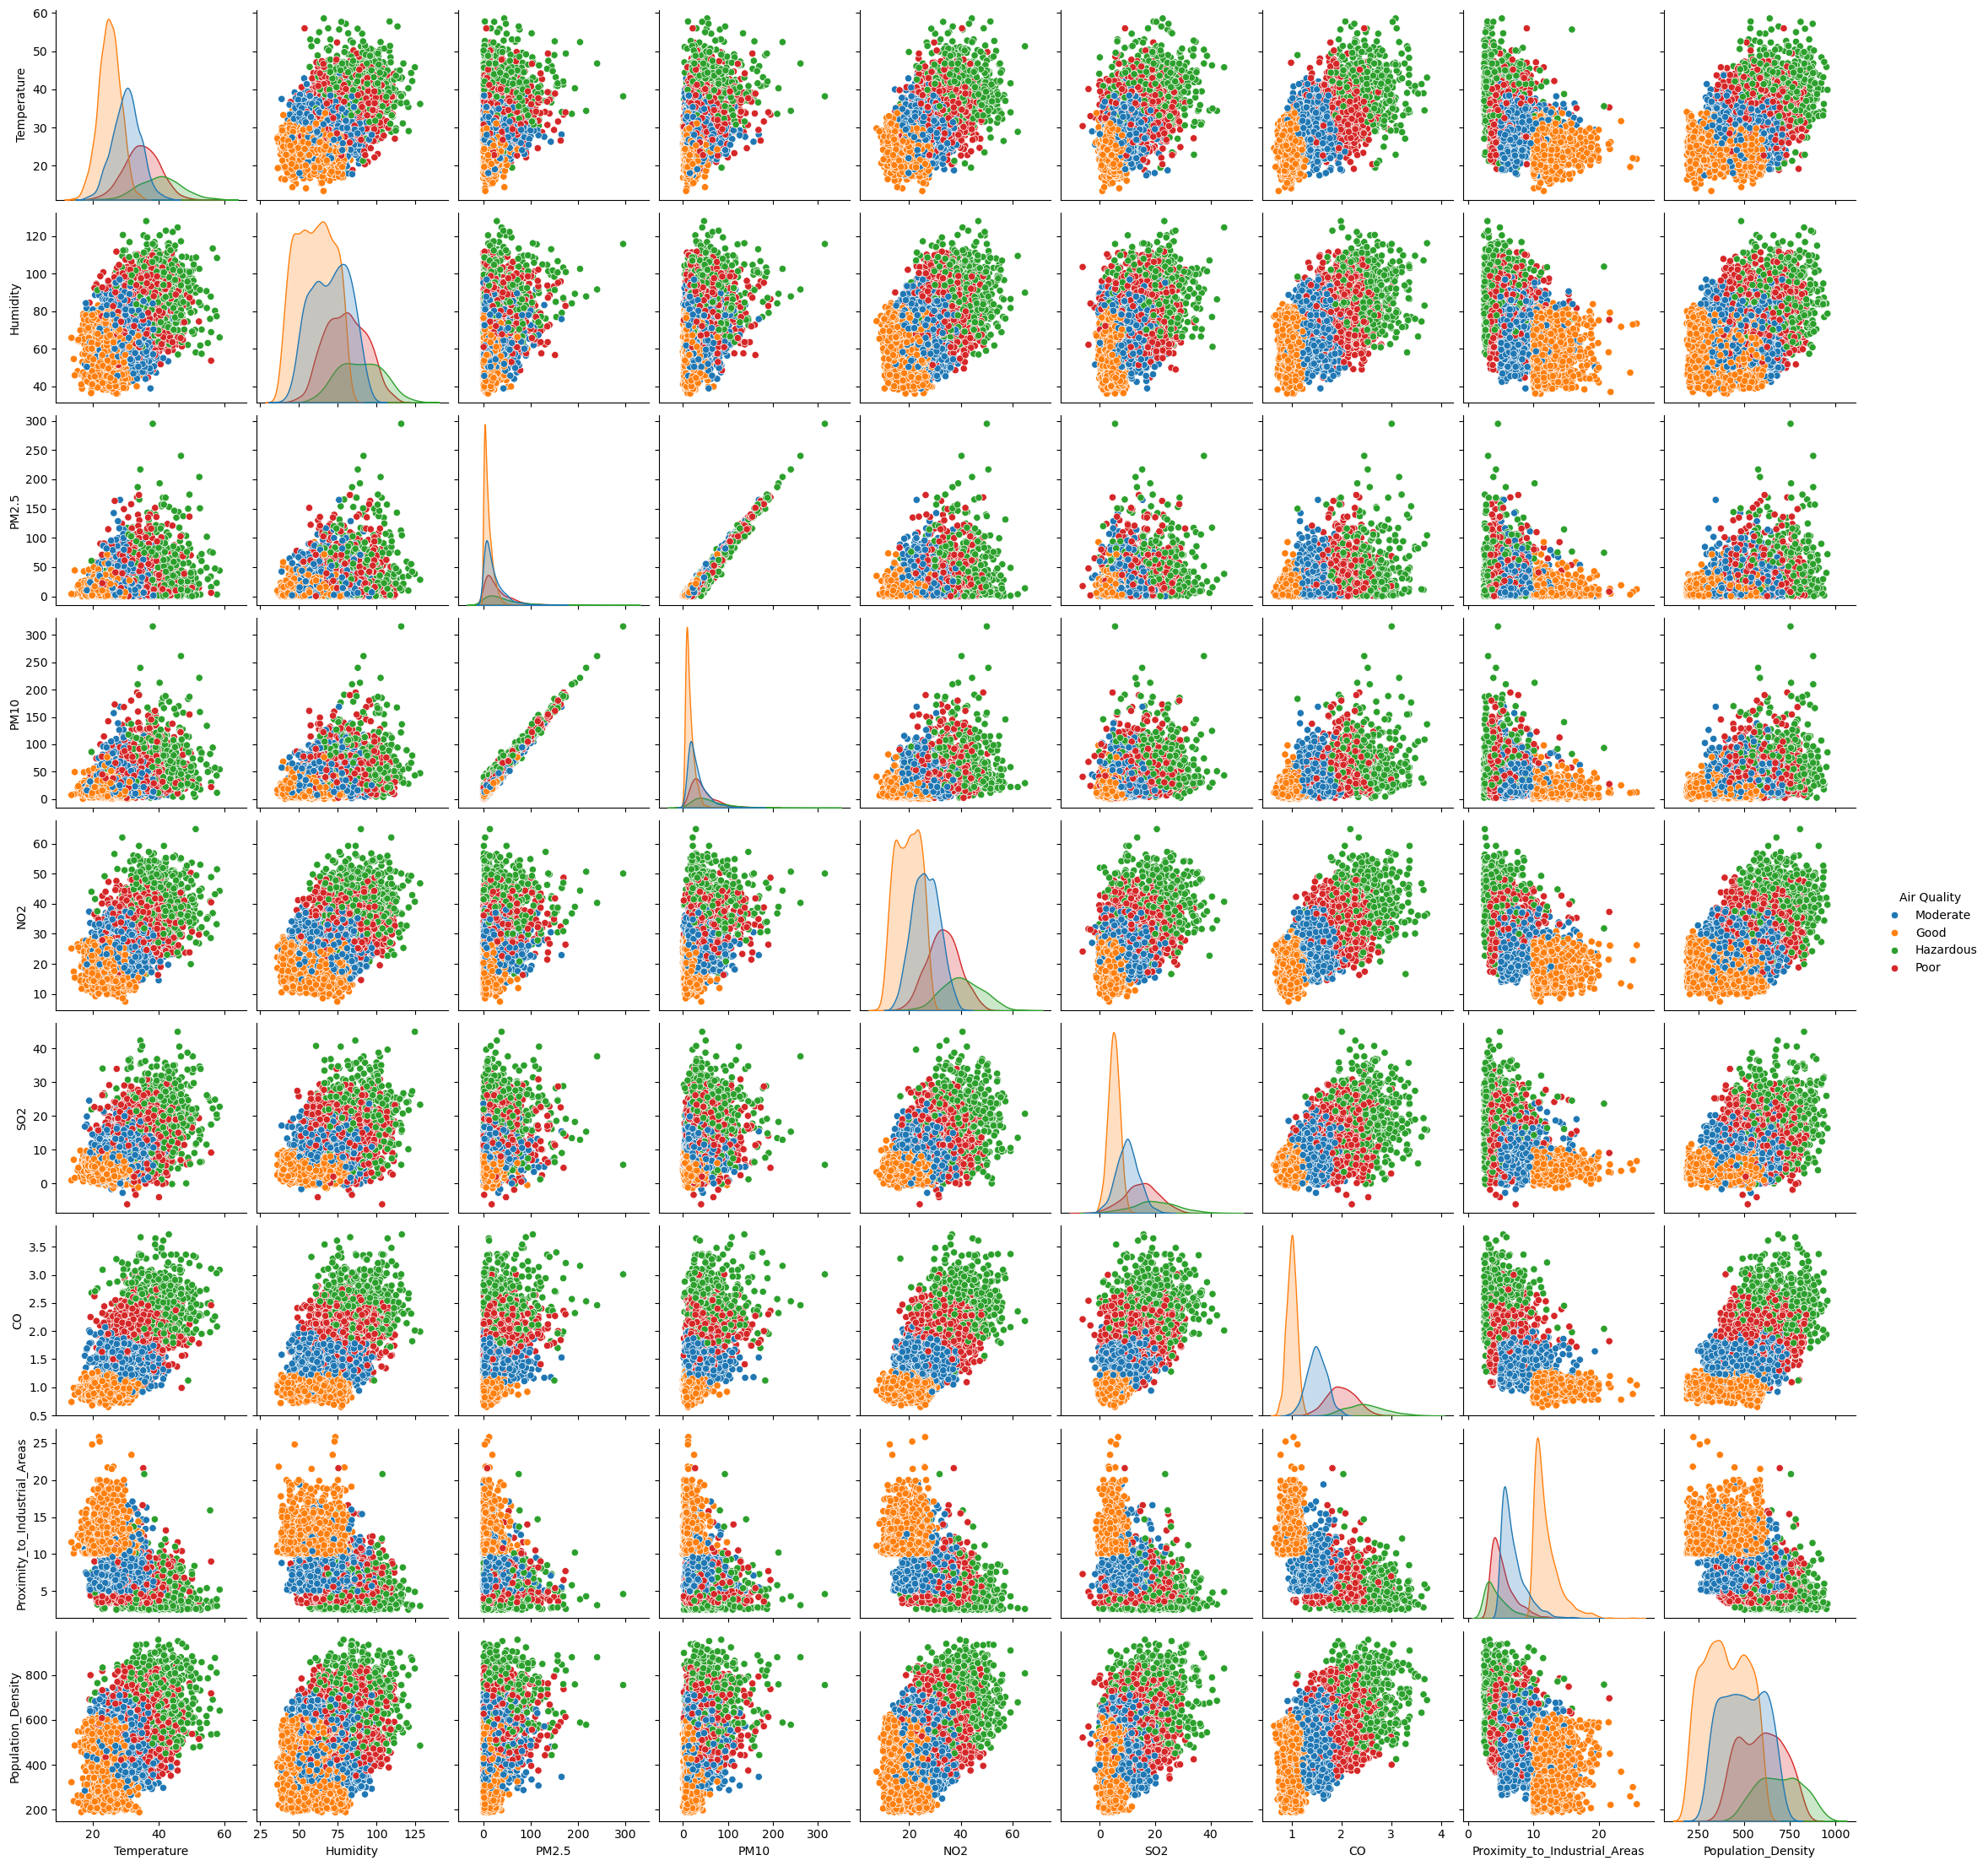

In [9]:
sns.pairplot(data = df, hue = 'Air Quality')
plt.show()

### *Visualizing distributions of features*

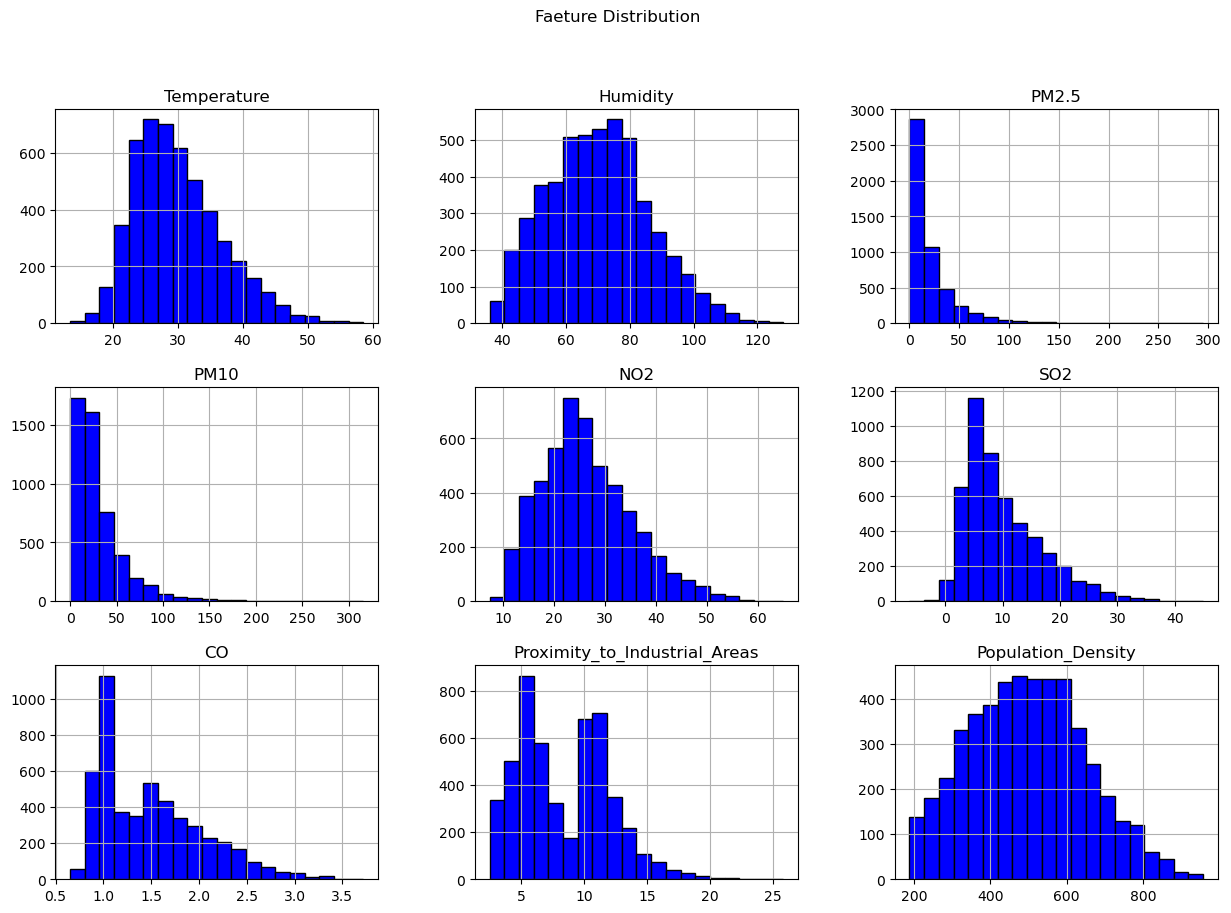

In [11]:
df.hist(bins = 20, figsize = (15,10), color = 'blue',edgecolor = 'black')
plt.suptitle("Faeture Distribution")
plt.show()

**The dataset contains well-distributed features like temperature, humidity, and pollutant concentrations.**

**Features are distributed with varying skewness (e.g., CO is skewed).**


**Populations and pollution levels vary significantly between regions.**

### *Countplot for target variable*

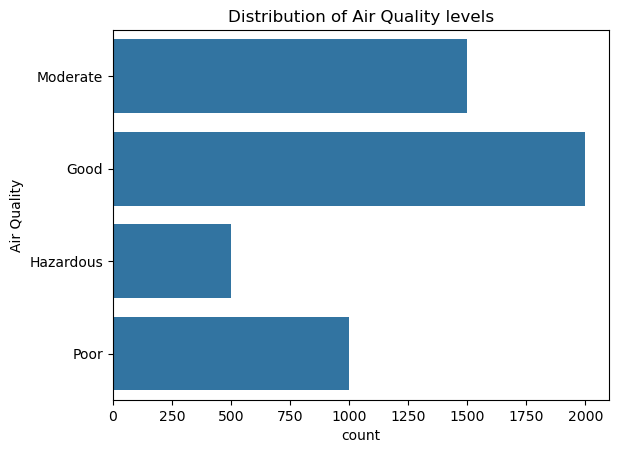

In [14]:
sns.countplot(df['Air Quality'])
plt.title("Distribution of Air Quality levels")
plt.show()

**The target variable is imbalanced, with some categories (like "Poor" or "Hazardous") being less frequent.**

## Step 2: Handle Missing Values and Detect Outliers

In [17]:
# Check for missing values
print("Missing Values:\n",df.isnull().sum())

Missing Values:
 Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


**There is no missing values in given dataset.**

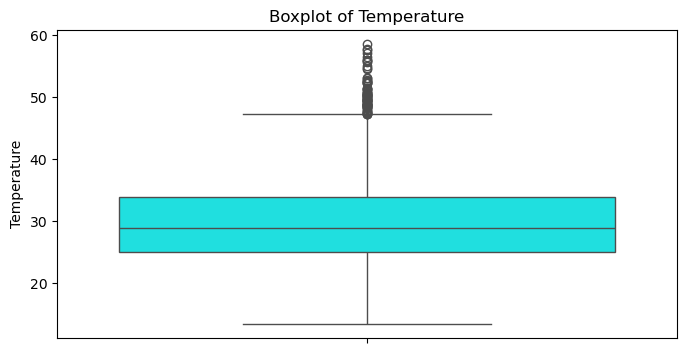

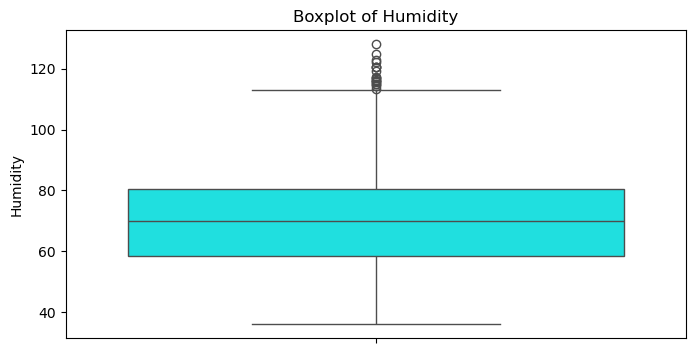

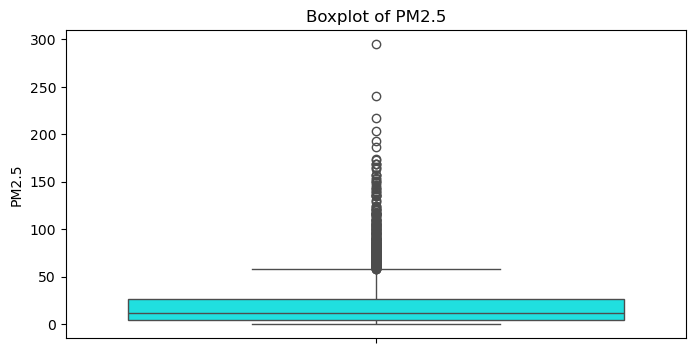

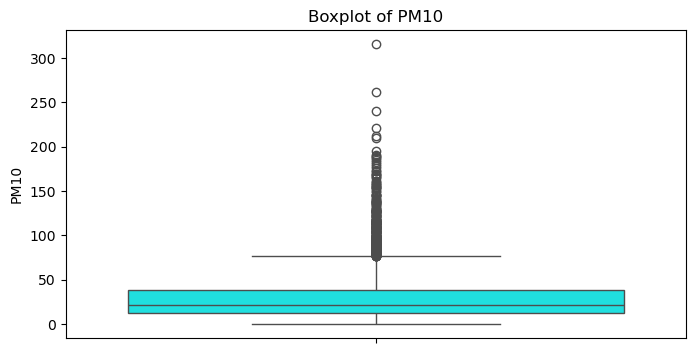

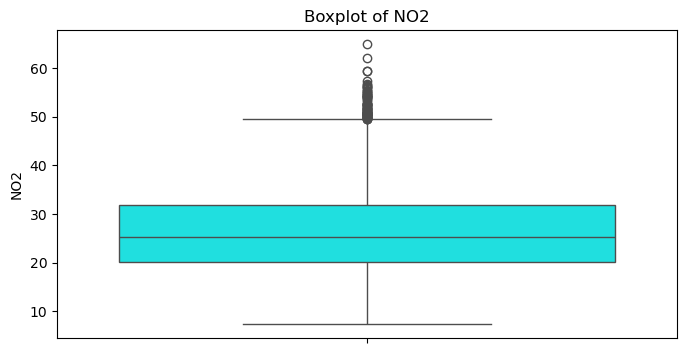

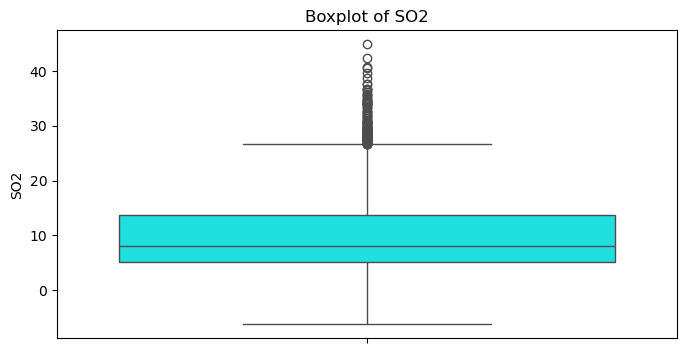

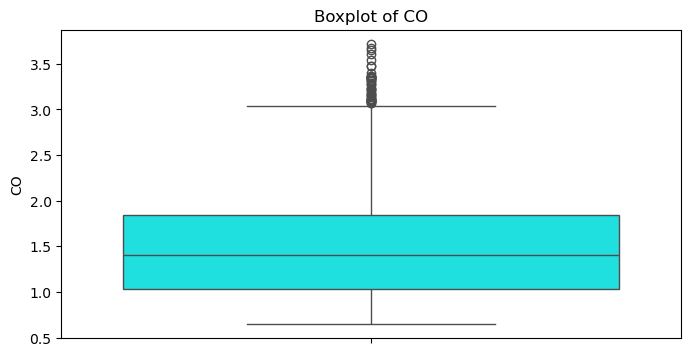

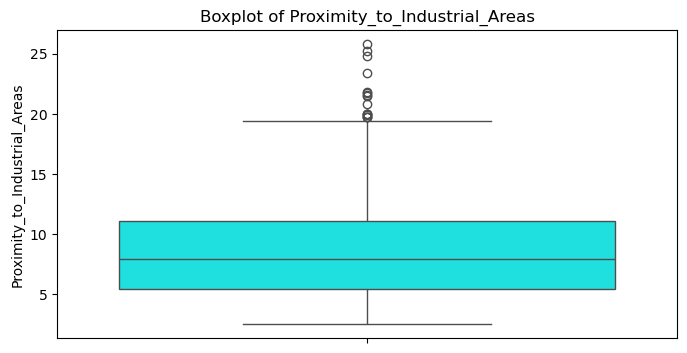

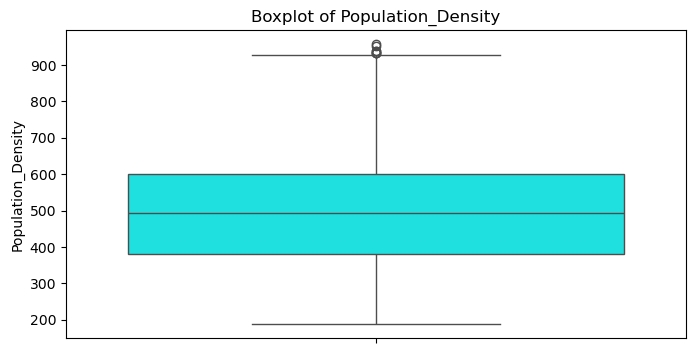

In [19]:
# Outlier detection using boxplots
for column in df.select_dtypes(include = [np.number]).columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(df[column],color = 'cyan')
    plt.title(f"Boxplot of {column}")
    plt.show()

**-features with significant outliers (e.g., PM2.5, PM10, CO concentrations).**


  **1.Features like PM2.5 and PM10 show significant outliers, indicating extreme pollution levels in some regions.**


  
  **2.Outliers are handled using the Interquartile Range (IQR) method to maintain the integrity of the analysis.**

In [21]:
# Removing outliers using IQR
def remove_outliers(df1,column):
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5*IQR
    upper_fence = Q3 + 1.5*IQR
    return df1[(df1[column] >= lower_fence) & (df1[column] <= upper_fence)]

for col in df.select_dtypes(include = [np.number]).columns:
    df = remove_outliers(df , col)

print("Data after outlier removal:", df.shape)

Data after outlier removal: (4158, 10)


### Correlation Analysis

In [23]:
numeric_cols = df.select_dtypes(include = [np.number])

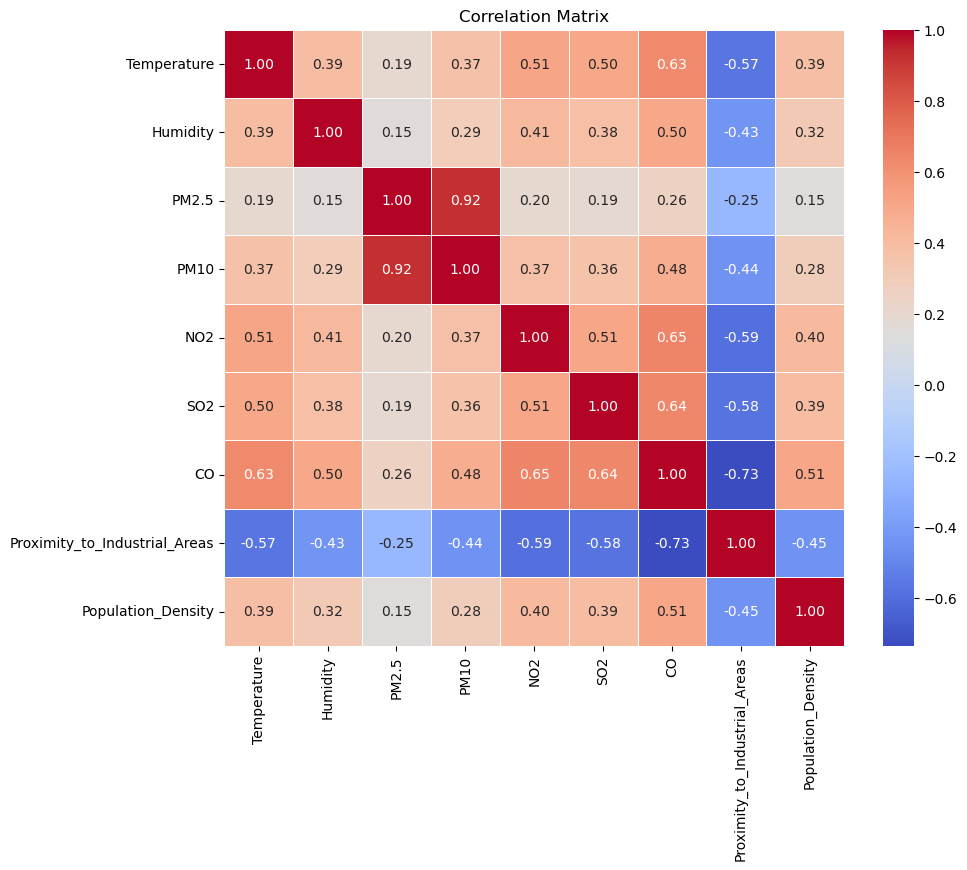

In [24]:
plt.figure(figsize = (10,8))
sns.heatmap(numeric_cols.corr() , annot = True , cmap = 'coolwarm', linewidth =  0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

1. High positive correlation observed between PM2.5 and PM10 concentrations, suggesting they often increase together.
2. Weak correlation between pollutant concentrations and proximity to industrial areas.

**#Note: I have also check by removing one of the feature from PM10 and PM2.5 as having correlation coeffiecient values 0.92 
which can cause the colinearity problem, but there is very minor change observed in accuracy, so as consequence I move forward by keeping
both the features here.**

## Step 3. Feature Engineering

Label encoding for target feature

Moderate : 2 , Good : 0 , Hazardous : 1, Poor: 3

In [29]:
# Encode the target variable
label_encoder = LabelEncoder()
df['Air Quality'] = label_encoder.fit_transform(df['Air Quality'])

In [30]:
# Split dataset into features (X) and target (y)
X = df.drop(columns = ['Air Quality'])
y = df['Air Quality']

In [159]:
y.head(7)

0    2
1    2
2    2
3    0
4    0
5    1
6    3
Name: Air Quality, dtype: int32

In [32]:
# Train-test split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size  = 0.2, random_state = 42)

In [33]:
X_train.shape

(3326, 9)

In [34]:
X_test.shape

(832, 9)

**Feature Scaling**

In [36]:
#Scaling the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Step 4: Model Building

### 1.LogisticRegression

In [39]:
lr = LogisticRegression()
lr.fit(X_train_s, y_train)

LogisticRegression()

In [40]:
y_pred_test_lr = lr.predict(X_test_s)
y_pred_train_lr = lr.predict(X_train_s)

In [41]:
print(classification_report(y_test , y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       391
           1       0.77      0.50      0.61        20
           2       0.95      0.95      0.95       286
           3       0.85      0.87      0.86       135

    accuracy                           0.95       832
   macro avg       0.89      0.83      0.85       832
weighted avg       0.95      0.95      0.95       832



In [42]:
y_pred_prob_lr = lr.predict_proba(X_test_s)

In [43]:
lr_roc_score = roc_auc_score(y_test, y_pred_prob_lr, multi_class = 'ovr') # multi_class Only used for multiclass targets. am using ovo cuz target variable is imbalance
lr_roc_score

0.9894376732826009

In [44]:
# Evaluating Model performance
print(classification_report(y_train, y_pred_train_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1589
           1       0.88      0.51      0.64        69
           2       0.95      0.97      0.96      1103
           3       0.89      0.88      0.89       565

    accuracy                           0.96      3326
   macro avg       0.93      0.84      0.87      3326
weighted avg       0.96      0.96      0.96      3326



### 2.Decision tree CLassifier

In [46]:
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train_s, y_train)

DecisionTreeClassifier(max_depth=3)

In [47]:
y_pred_test_dt = dt.predict(X_test_s)
y_pred_train_dt = dt.predict(X_train_s)

In [48]:
# Evaluating Model performance
print(classification_report(y_test, y_pred_test_dt))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       391
           1       0.83      0.25      0.38        20
           2       0.91      0.92      0.91       286
           3       0.76      0.88      0.82       135

    accuracy                           0.92       832
   macro avg       0.88      0.76      0.77       832
weighted avg       0.92      0.92      0.92       832



**by Decision tree accuracy_score is descreased**

In [50]:
# predicting the probabilities 
y_pred_prob_dt = dt.predict_proba(X_test_s)

In [51]:
dt_roc_score = roc_auc_score(y_test , y_pred_prob_dt , multi_class = 'ovr')
dt_roc_score

0.9588271300803646

###  Plotting decision tree**

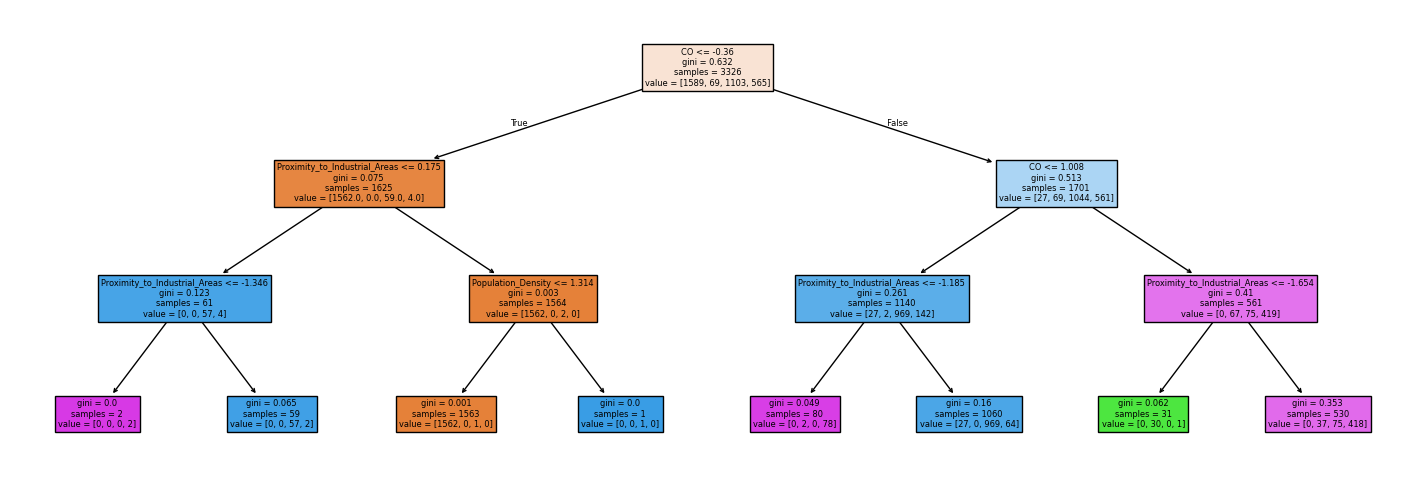

In [53]:
plt.figure(figsize = (18,6))
plot_tree(dt, feature_names = X_train.columns, filled = True)
plt.show()

### 3.Randome Forest Classifier

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train_s , y_train)

RandomForestClassifier()

In [56]:
y_pred_test_rf = rf.predict(X_test_s)
y_pred_prob_rf = rf.predict_proba(X_test_s)

In [57]:
# Evaluating Model performance
print(classification_report(y_test , y_pred_test_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      0.40      0.57        20
           2       0.95      0.98      0.97       286
           3       0.88      0.90      0.89       135

    accuracy                           0.96       832
   macro avg       0.96      0.82      0.86       832
weighted avg       0.96      0.96      0.96       832



In [58]:
rf_roc_score = roc_auc_score(y_test , y_pred_prob_rf , multi_class = 'ovr')
rf_roc_score

0.9906268061120678

### 4. Gradient Boosting Classifier

In [60]:
gbc = GradientBoostingClassifier(learning_rate = 0.3 , n_estimators = 500 , max_depth = 3)
gbc.fit(X_train_s, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=500)

In [61]:
y_pred_test_gbc = gbc.predict(X_test_s)
y_pred_prob_gbc = gbc.predict_proba(X_test_s)

In [62]:
# Evaluating Model performance
print(classification_report(y_test, y_pred_test_gbc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       0.82      0.45      0.58        20
           2       0.95      0.98      0.96       286
           3       0.87      0.87      0.87       135

    accuracy                           0.96       832
   macro avg       0.91      0.82      0.85       832
weighted avg       0.96      0.96      0.95       832



In [63]:
gbc_roc_score = roc_auc_score(y_test, y_pred_prob_gbc, multi_class = 'ovr')
gbc_roc_score

0.9855984617311676

### 5. Support vector classifier

In [65]:
svc = SVC()
svc.fit(X_train_s, y_train)

SVC()

In [66]:
y_pred_test_svc = svc.predict(X_test_s)

In [67]:
# Evaluating Model performance
print(classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       0.89      0.40      0.55        20
           2       0.96      0.98      0.97       286
           3       0.88      0.90      0.89       135

    accuracy                           0.96       832
   macro avg       0.93      0.82      0.85       832
weighted avg       0.96      0.96      0.96       832



**Note: all models are giving same accuracy 0.96 except decision tree which 0.92.**


### Hyper parameter tunning for Random Forest to fine tune the model

## **Final Model for this problem*

In [116]:
# Define the parameter grid
param_grid = {
    'n_estimators':[100,200,300],     # Number of trees in the forest
    'max_depth': [10,20,30],          # Maximum depth of the trees
    'min_samples_split':[2,5],        # Minimum samples required to split a node
    'min_samples_leaf':[1,2],         # Minimum samples required to be at a leaf node
    'max_features':['sqrt' ,'log2'] , # Number of features to consider at each split
    'bootstrap':[True , False]        # Use bootstrap samples or not
}

In [118]:
grid_search = GridSearchCV(rf ,param_grid ,scoring = 'accuracy', cv = 5 , n_jobs = -1)

In [120]:
grid_search.fit(X_train_s , y_train)

C:\Users\MQT\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [126]:
# Best parameters and best score
print("Best Parameters:"  ,grid_search.best_params_)
print("Best Score :",  grid_search.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score : 0.9702341439183545


In [128]:
# Train the best model on the training data
best_rf = grid_search.best_estimator_

In [130]:
y_pred_best_rf = best_rf.predict(X_test_s)

In [138]:
# Evaluating Model performance
print(classification_report(y_test , y_pred_best_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      0.50      0.67        20
           2       0.96      0.98      0.97       286
           3       0.89      0.92      0.90       135

    accuracy                           0.97       832
   macro avg       0.96      0.85      0.88       832
weighted avg       0.97      0.97      0.96       832



#### **Let's visualise its results*

<Figure size 600x400 with 0 Axes>

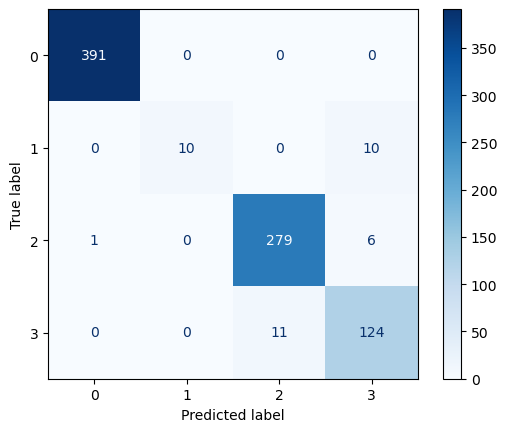

In [152]:
# Confusion Matrix Visualization
plt.figure(figsize = (6,4))
ConfusionMatrixDisplay.from_estimator(best_rf , X_test_s ,y_test, cmap = "Blues" , colorbar = True)
plt.show()

#### Feature Importance:
Visualize the feature importance to show which features contributed most to the predictions

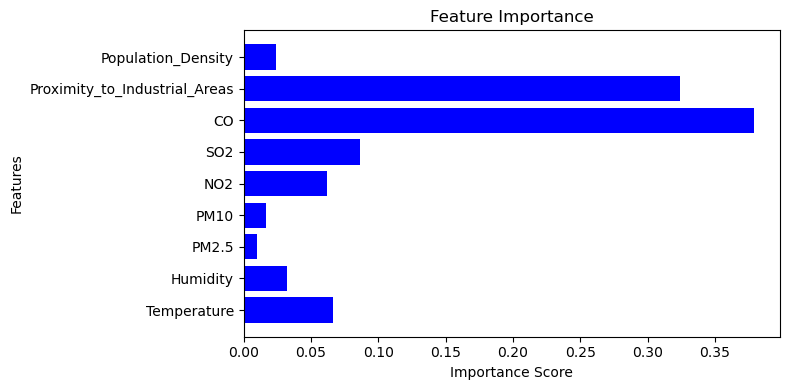

In [172]:
importances = best_rf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize = (8,4))
plt.barh(feature_names , importances , color = 'Blue')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### as from above Horizonatal bar plot, can see which are most features contributing:
  1. Proximity_to_Industrial_Areas: it clearly says that Industry/Factories areas are more dominating to Pollution/Air Quality
  2. CO : Carbon Mono Oxide
  3. SO2: Sulphur Di_oxide
  4. Temperature
  5. Somewhere Population Density and Humidity also impacting Air Quality

### ROC Curve: plotting ROC curve for model's performance

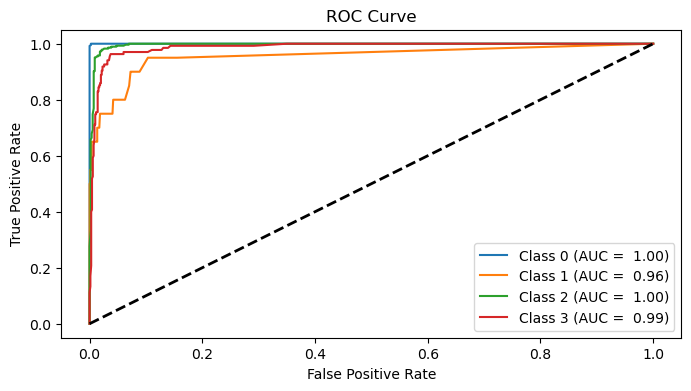

In [179]:
y_prob = best_rf.predict_proba(X_test_s)


plt.figure(figsize= (8,4))

for i in range (y_prob.shape[1]):   # y_prob.shape[1] refers to the number of classes in the classification problem. _: Threshold values (not used in the plot here
    fpr, tpr , _ = roc_curve(y_test == i , y_prob[:,i]) # y_test == i: Converts y_test into a binary format for the current class i, y_prob[:, i]: This is the predicted probability of the test samples belonging to class i
    roc_auc = auc(fpr , tpr)
    plt.plot(fpr , tpr, label = f"Class {i} (AUC = {roc_auc : .2f})")

plt.plot([0,1],[0,1], 'k--' , lw = 2)  # adding a ref dotted line diagonally
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc = "lower right")
plt.show()

## Insights on the ROC Curve:

1. High Model Performance Across Classes:
   * The AUC (Area Under the Curve) values for all classes are very high:
     * Class 0 (Good): AUC = 1.00
     * Class 1 (Hardeous): AUC = 0.96
     * Class 2 (Moderate): AUC = 1.00
     * Class 3 (Poor): AUC = 0.99
  * This indicates that the model is highly capable of distinguishing between different classes.

2. Baseline Comparison:
   * The dotted diagonal line represents a random classifier with an AUC = 0.5.
   * All ROC curves for the model are far above this line, demonstrating the model's strong discriminative power.

3. True Positive Rate vs. False Positive Rate:
   * The ROC curves are tightly hugging the top-left corner, indicating a high true positive rate (sensitivity) and a low false positive rate, which        confirms excellent classification performance.

## 1. This tunned random forest model gives us better performance metrics in comparision to other models.

   * Accuracy on Test Data: 97.0%
   * Precision, Recall, and F1-Score for all classes are consistently high, indicating a well-balanced model.
   * Class 1, which had slightly lower performance in earlier iterations, has improved (Precision: 0.67, Recall: 0.50).


## 2.Insights:
  * The model shows consistent performance across all classes, with particularly high precision and recall for the majority class (Class 0).
  * The slight improvement in accuracy and F1-score after hyperparameter tuning validates the importance of parameter optimization.

## 3. Why This Model?:
  * Random Forest handles multicollinearity well, which was observed in the dataset (e.g., high correlation between PM2.5 and PM10).
  * It also reduces the risk of overfitting compared to Decision Trees, which performed poorly (accuracy: 92%).